In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
#load datasets
df = pd.read_csv('/content/heart_disease.txt')

In [3]:
df.head()

,63.0,1.0,1.0.1,145.0,233.0,1.0.2,2.0,150.0,0.0,2.3,3.0,0.0.1,6.0,0
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


In [4]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   63.0    302 non-null    float64
 1   1.0     302 non-null    float64
 2   1.0.1   302 non-null    float64
 3   145.0   302 non-null    float64
 4   233.0   302 non-null    float64
 5   1.0.2   302 non-null    float64
 6   2.0     302 non-null    float64
 7   150.0   302 non-null    float64
 8   0.0     302 non-null    float64
 9   2.3     302 non-null    float64
 10  3.0     302 non-null    float64
 11  0.0.1   302 non-null    object 
 12  6.0     302 non-null    object 
 13  0       302 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.2+ KB


In [5]:
df.shape

(302, 14)

# Feature Renaming

In [6]:
#adjusting column names to meaningful one
df=df.rename(columns={
    '63.0': 'age',
    '1.0': 'gender',
    '1.0.1' : 'chest_pain_type',
    '145.0': 'trestbps',
    '233.0': 'chol',
    '1.0.2': 'fasting_blood_sugar',
    '2.0' : 'resting_electrocardiographic_results',
    '150.0': 'maximum_heart_rate_achieved',
    '0.0': 'exercise_induced_angina',
    '2.3': 'oldpeak',
    '3.0': 'slope',
    '0.0.1': 'num_major_vessels',
    '6.0': 'thal',
    '0': 'target'
})


In [7]:
#checking results
df.head()

,age,gender,chest_pain_type,trestbps,chol,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,num_major_vessels,thal,target
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


# Data preprocessing

In [8]:
#adjusting the data types for the columns
for col in df.columns:
  if col != 'oldpeak':
    # Convert '?' to NaN which can be handled by to_numeric
    df[col] = df[col].replace('?', np.nan)
    # Convert to numeric first
    df[col] = pd.to_numeric(df[col])
    # Check if column is num_major_vessels or thal and convert to Int64
    if col in ['num_major_vessels', 'thal']:
        # Fill NaN values with -1 before converting to Int64
        df[col] = df[col].fillna(-1).astype('int64')
    elif not df[col].isnull().values.any():
        df[col] = df[col].astype('int64')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   302 non-null    int64  
 1   gender                                302 non-null    int64  
 2   chest_pain_type                       302 non-null    int64  
 3   trestbps                              302 non-null    int64  
 4   chol                                  302 non-null    int64  
 5   fasting_blood_sugar                   302 non-null    int64  
 6   resting_electrocardiographic_results  302 non-null    int64  
 7   maximum_heart_rate_achieved           302 non-null    int64  
 8   exercise_induced_angina               302 non-null    int64  
 9   oldpeak                               302 non-null    float64
 10  slope                                 302 non-null    int64  
 11  num_major_vessels  

In [10]:
#there are features that are indeed numerical in terms of data type, but categorical in terms of their semantics,so need to change them
# Define the continuous features
continuous_features = ['age', 'trestbps', 'chol', 'oldpeak','maximum_heart_rate_achieved']

# Identify the features to be converted to object data type
features_to_convert = [feature for feature in df.columns if feature not in continuous_features]

# Convert the identified features to object data type
df[features_to_convert] = df[features_to_convert].astype('object')
df['maximum_heart_rate_achieved'] = df['maximum_heart_rate_achieved'].astype(int)
df.dtypes

,0
age,int64
gender,object
chest_pain_type,object
trestbps,int64
chol,int64
fasting_blood_sugar,object
resting_electrocardiographic_results,object
maximum_heart_rate_achieved,int64
exercise_induced_angina,object
oldpeak,float64


In [11]:
# Get the summary statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,302.0,54.410596,9.040163,29.0,48.00,55.5,61.0,77.0
trestbps,302.0,131.645695,17.612202,94.0,120.00,130.0,140.0,200.0
chol,302.0,246.738411,51.856829,126.0,211.00,241.5,275.0,564.0
maximum_heart_rate_achieved,302.0,149.605960,22.912959,71.0,133.25,153.0,166.0,202.0
oldpeak,302.0,1.035430,1.160723,0.0,0.00,0.8,1.6,6.2


-the average of patients is 54 years the youngest is 29 years and oldest is 77 years


In [12]:
df.describe(include='object').T

,count,unique,top,freq
gender,302,2,1,205
chest_pain_type,302,4,4,144
fasting_blood_sugar,302,2,0,258
resting_electrocardiographic_results,302,3,0,151
exercise_induced_angina,302,2,0,203
slope,302,3,1,142
num_major_vessels,302,5,0,175
thal,302,4,3,166
target,302,5,0,163


In [13]:
df['target'].value_counts()

,count
target,
0,163
1,55
2,36
3,35
4,13


In [14]:
# Binarize the target variable
df['target'] = np.int64(df['target'] > 0)
print('\nAfter binarization: \n', df['target'].value_counts())


After binarization: 
 target
0    163
1    139
Name: count, dtype: int64


In [15]:
#counting null values
df.isnull().sum()

,0
age,0
gender,0
chest_pain_type,0
trestbps,0
chol,0
fasting_blood_sugar,0
resting_electrocardiographic_results,0
maximum_heart_rate_achieved,0
exercise_induced_angina,0
oldpeak,0


In [16]:
#checking duplicate rows
df.duplicated().sum()

0

# Univariate Analysis

<ipython-input-17-08c475db87d9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="target", data=df, palette=palette)


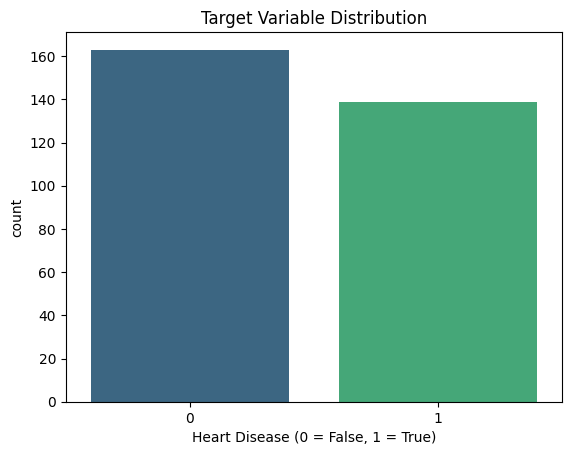

In [17]:
palette = "viridis"
sns.countplot(x="target", data=df, palette=palette)
plt.xlabel("Heart Disease (0 = False, 1 = True)")
plt.title('Target Variable Distribution')
plt.show()

<ipython-input-18-bf12accc45ca>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="gender", data=df, palette=palette)


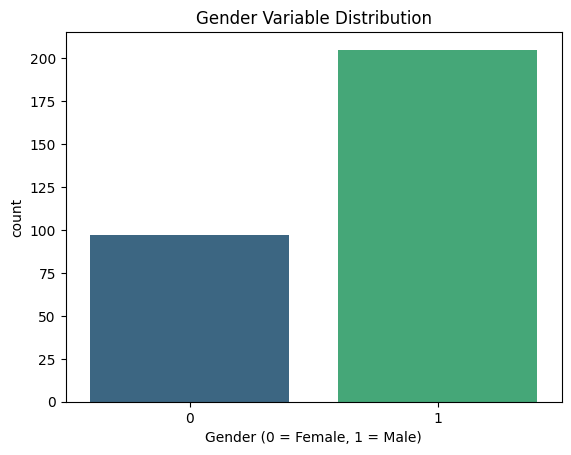

In [18]:
sns.countplot(x="gender", data=df, palette=palette)
plt.xlabel("Gender (0 = Female, 1 = Male)")
plt.title('Gender Variable Distribution')
plt.show()

Number of Male patients more than the number of Female patients

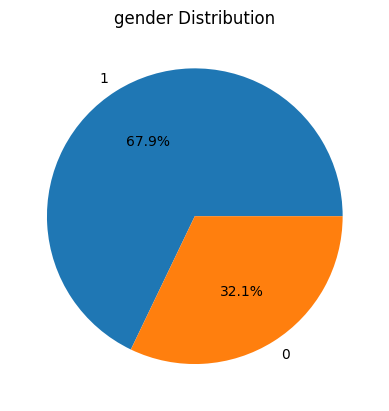

In [19]:
sex_count = df['gender'].value_counts()
plt.pie(sex_count, labels=sex_count.index, autopct='%1.1f%%')
plt.title('gender Distribution')
plt.show()

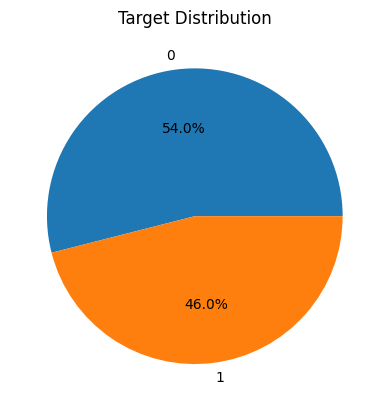

In [20]:
target_count = df['target'].value_counts()
plt.pie(target_count, labels=target_count.index, autopct='%1.1f%%')
plt.title('Target Distribution')
plt.show()

<ipython-input-21-fac6208ac593>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x="age", data=df, palette=palette)


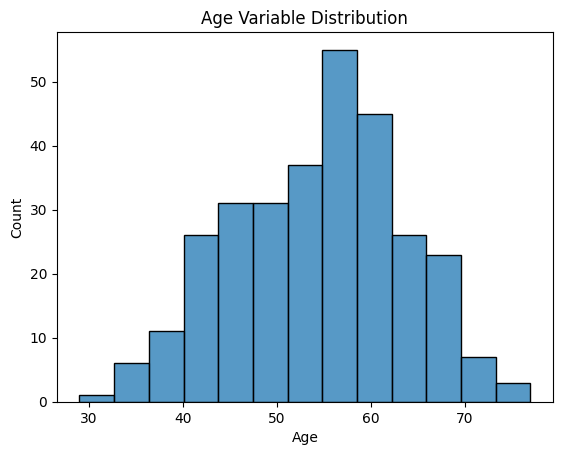

In [21]:
sns.histplot(x="age", data=df, palette=palette)
plt.xlabel("Age")
plt.title('Age Variable Distribution')
plt.show()

<ipython-input-22-2cc895186286>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x="trestbps", data=df, palette=palette)


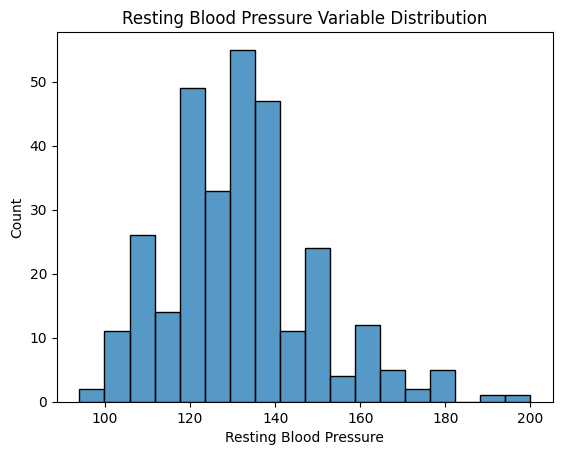

In [22]:
sns.histplot(x="trestbps", data=df, palette=palette)
plt.xlabel("Resting Blood Pressure")
plt.title('Resting Blood Pressure Variable Distribution')
plt.show()

we can conclude that the majority of individuals in the sample have Resting blood presure levels between 120 and 140 mg/dL, with a smaller number of individuals having higher or lower blood pressure levels

<ipython-input-23-cdff1d015950>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x="chol", data=df, palette=palette)


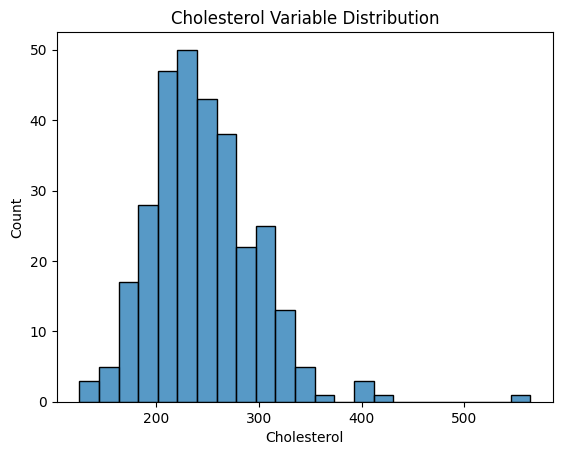

In [23]:
sns.histplot(x="chol", data=df, palette=palette)
plt.xlabel("Cholesterol")
plt.title('Cholesterol Variable Distribution')
plt.show()

we can conclude that the majority of individuals in the sample have cholesterol levels between 200 and 300 mg/dL, with a smaller number of individuals having higher or lower cholesterol levels

<ipython-input-24-28ccf10a2c7a>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x="chest_pain_type", data=df, palette=palette)


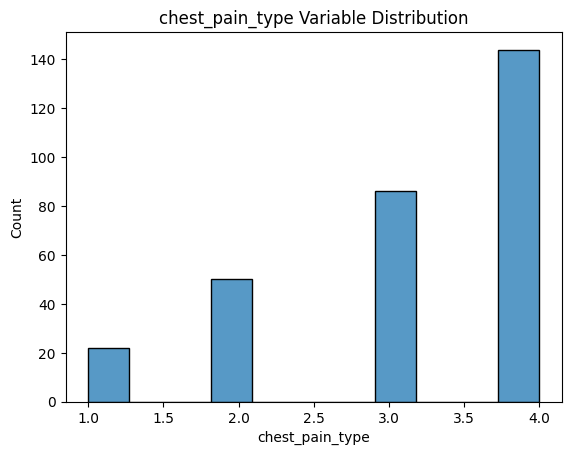

In [24]:
sns.histplot(x="chest_pain_type", data=df, palette=palette)
plt.xlabel("chest_pain_type")
plt.title('chest_pain_type Variable Distribution')
plt.show()

The 4th type is the maximum one

<ipython-input-25-56e47c4e028c>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x="resting_electrocardiographic_results", data=df, palette=palette)


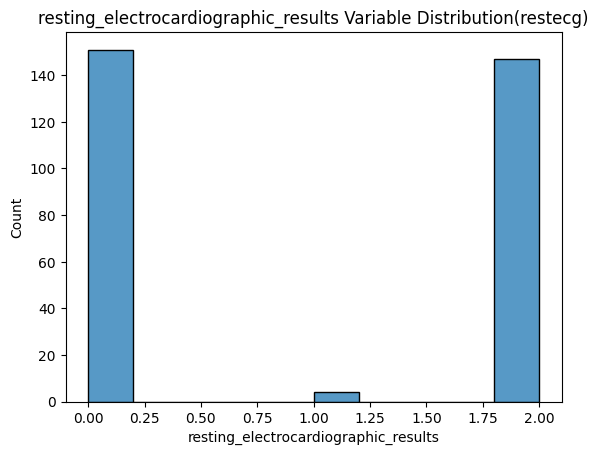

In [25]:
sns.histplot(x="resting_electrocardiographic_results", data=df, palette=palette)
plt.xlabel("resting_electrocardiographic_results")
plt.title('resting_electrocardiographic_results Variable Distribution(restecg)')
plt.show()


<ipython-input-26-6f1638d7c7d7>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(x="maximum_heart_rate_achieved", data=df, palette=palette)


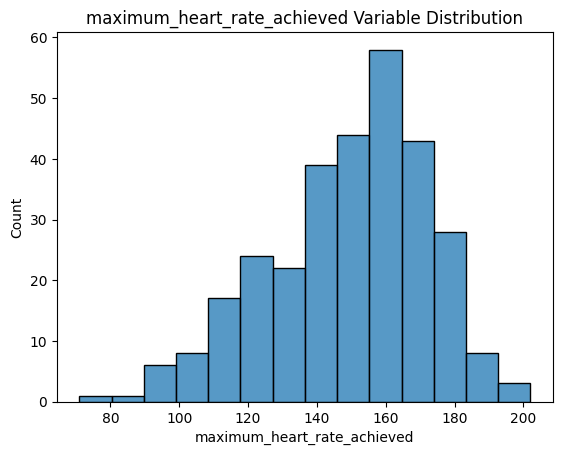

In [26]:
sns.histplot(x="maximum_heart_rate_achieved", data=df, palette=palette)
plt.xlabel("maximum_heart_rate_achieved")
plt.title('maximum_heart_rate_achieved Variable Distribution')
plt.show()


we can conclude that the majority of individuals in the sample have max heart  levels between 140 and 180 , with a smaller number of individuals having higher or lower heart rate levels

# Bivariant analysis

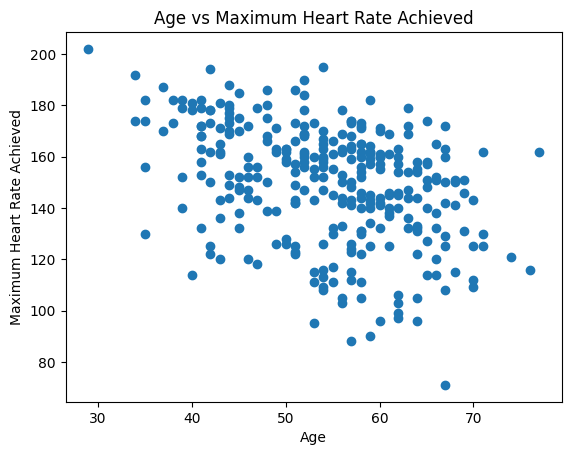

In [27]:
plt.scatter(df['age'], df['maximum_heart_rate_achieved'])
plt.title('Age vs Maximum Heart Rate Achieved')
plt.xlabel('Age')
plt.ylabel('Maximum Heart Rate Achieved')
plt.show()

there is a slightly negative correlation between age and heart rate

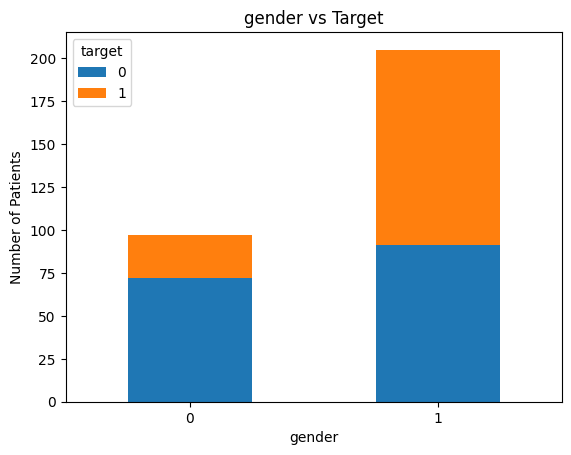

In [28]:
sex_target = df.groupby(['gender', 'target']).size().unstack().fillna(0)
sex_target.plot(kind='bar', stacked=True)
plt.title('gender vs Target')
plt.xlabel('gender')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.show()

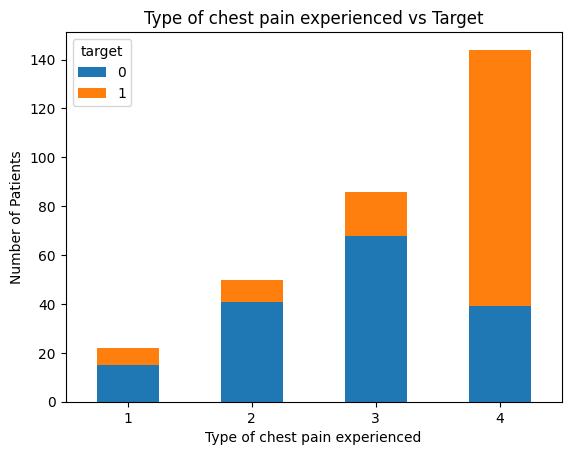

In [29]:
ca_target = df.groupby(['chest_pain_type', 'target']).size().unstack().fillna(0)
ca_target.plot(kind='bar', stacked=True)
plt.title('Type of chest pain experienced vs Target')
plt.xlabel('Type of chest pain experienced')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.show()

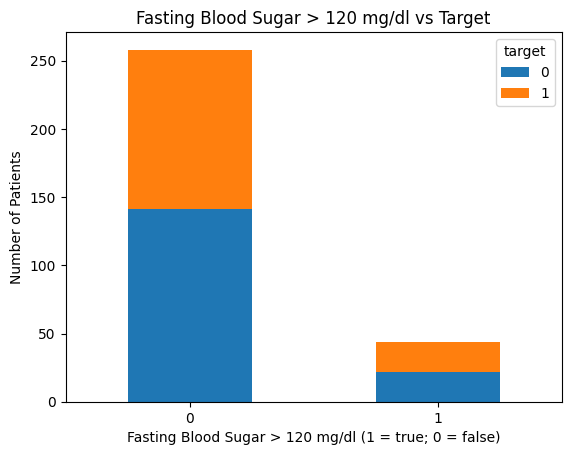

In [30]:
fbs_target = df.groupby(['fasting_blood_sugar', 'target']).size().unstack().fillna(0)
fbs_target.plot(kind='bar', stacked=True)
plt.title('Fasting Blood Sugar > 120 mg/dl vs Target')
plt.xlabel('Fasting Blood Sugar > 120 mg/dl (1 = true; 0 = false)')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.show()

# Removing Outliers

In [31]:
continuous_features

['age', 'trestbps', 'chol', 'oldpeak', 'maximum_heart_rate_achieved']

In [32]:


# Calculate Q1, Q3, and IQR
Q1 = df[continuous_features].quantile(0.25)
Q3 = df[continuous_features].quantile(0.75)
IQR = Q3 - Q1

# Calculate the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count the outliers in the specified columns
outliers_count_specified = ((df[continuous_features] < lower_bound) | (df[continuous_features] > upper_bound)).sum()
print("Outliers count per feature:\n", outliers_count_specified)

# Filter the DataFrame to remove outliers
df = df[~((df[continuous_features] < lower_bound) | (df[continuous_features] > upper_bound)).any(axis=1)]
#check this step
outliers_count_specified = ((df[continuous_features] < lower_bound) | (df[continuous_features] > upper_bound)).sum()
print("Outliers count per feature:\n", outliers_count_specified)


Outliers count per feature:
 age                            0
trestbps                       9
chol                           5
oldpeak                        5
maximum_heart_rate_achieved    1
dtype: int64
Outliers count per feature:
 age                            0
trestbps                       0
chol                           0
oldpeak                        0
maximum_heart_rate_achieved    0
dtype: int64


# Standardization & One-Hot Encoding

In [33]:
numerical_features = []
categorical_features = []

for col in df.columns:
  if df[col].dtype in ['int64', 'float64']:
    numerical_features.append(col)
  else:
    categorical_features.append(col)

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['age', 'trestbps', 'chol', 'maximum_heart_rate_achieved', 'oldpeak', 'target']
Categorical Features: ['gender', 'chest_pain_type', 'fasting_blood_sugar', 'resting_electrocardiographic_results', 'exercise_induced_angina', 'slope', 'num_major_vessels', 'thal']


In [34]:
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

df = pd.get_dummies(df, columns=categorical_features)

<ipython-input-34-2f929b930538>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical_features] = scaler.fit_transform(df[numerical_features])


# Label Spreading Model  

In [35]:
target_column = 'target'

# Extract features (X) and target (y)
X = df.drop(columns=[target_column])
y = df[target_column]

# Mask a significant portion of the dataset as unlabeled
rng = np.random.RandomState(42)
random_unlabeled_points = rng.rand(y.shape[0]) < 0.9  # 90% of the data is set to unlabeled
labels_heart = np.copy(y)
labels_heart[random_unlabeled_points] = -1  # Marking 90% of the labels as -1 (unlabeled)

# Splitting the data into training and testing sets
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(
    X, labels_heart, test_size=0.2, random_state=42
)

# Apply scaling
scaler = StandardScaler()
X_train_heart_scaled = scaler.fit_transform(X_train_heart)
X_test_heart_scaled = scaler.transform(X_test_heart)



In [36]:

label_spreading = LabelSpreading()



y_train_heart = y_train_heart.astype(int)
label_spreading.fit(X_train_heart_scaled, y_train_heart)

y_pred_test = label_spreading.predict(X_test_heart_scaled)
# Apply labeled_indices to y_pred_test to get corresponding predictions
labeled_indices = np.where(y_test_heart != -1)[0]
y_pred_test = y_pred_test[labeled_indices]
y_test_heart = y_test_heart[labeled_indices]

y_test_heart = y_test_heart.astype(int)
accuracy = accuracy_score(y_test_heart, y_pred_test)
print("Accuracy", accuracy)


Accuracy on held-out test set: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


# Label Propagation Model

In [39]:

label_propagation = LabelPropagation()



y_train_heart = y_train_heart.astype(int)
label_propagation.fit(X_train_heart_scaled, y_train_heart)

y_pred_test = label_propagation.predict(X_test_heart_scaled)
# Apply labeled_indices to y_pred_test to get corresponding predictions
labeled_indices = np.where(y_test_heart != -1)[0]
y_pred_test = y_pred_test[labeled_indices]
y_test_heart = y_test_heart[labeled_indices]

y_test_heart = y_test_heart.astype(int)
accuracy = accuracy_score(y_test_heart, y_pred_test)
print("Accuracy", accuracy)

Accuracy 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
